# Neural Network from Scratch
Code modified from https://github.com/adventuresinML/adventures-in-ml-code/blob/master/neural_network_tutorial.py

The notation in this website is almost the same as the notation we are using in class.  Instead of $a$ the author uses $h$, and instead of $N$, the author uses $m$. (I have modified the code below to use $a$ and $N$.)

Please read about this implementation starting at page 27 from the website listed above.

## The first thing we will do is import all the libraries

We will be using the lower resolution MINST data set

In [1]:
from sklearn.datasets import load_iris # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 


## Looking at the data

After we load the data, we print the shape of the data and a pixelated digit.

We also show what the features of one example looks like.

The neural net will learn to estimate which digit these pixels represent.

In [2]:
digits=load_iris()
X = digits.data
print("The shape of the digits dataset:") 
print(digits.data.shape)
#plt.gray()
#plt.matshow(digits.images[0])
#plt.show()
y = digits.target
print(y[0:1])
print(X[0,:])

The shape of the digits dataset:
(150, 4)
[0]
[5.1 3.5 1.4 0.2]


## 1) Scale the dataset
The training features range from 0 to 15.  To help the algorithm converge, we will scale the data to have a mean of 0 and unit variance

In [3]:
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

X[0,:] # Looking the new features after scaling

array([-0.90068117,  1.01900435, -1.34022653, -1.3154443 ])

## 2) Creating training and test datasets
We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset 

In [4]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

## 3) Setting up the output layer

### One hot encoding
Our target is an integer in the range [0,..,9], so we will have 10 output neuron's in our network.  

-  If  $y=0$, we want the output neurons to have the values $(1,0,0,0,0,0,0,0,0,0)$

-  If  $y=1$ we want the output neurons to have the values $(0,1,0,0,0,0,0,0,0,0)$
-  etc

Thus we need to change our target so it is the same as our hoped for output of the neural network.  
-  If $y=0$ we change it into the vector $(1,0,0,0,0,0,0,0,0,0)$. 
-  If $y=1$ we change it into the vector $(0,1,0,0,0,0,0,0,0,0)$
-  etc

See page 29 from the website listed above

The code to covert the target vector.

In [5]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 3))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

Converting the training and test targets to vectors 

In [6]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

A quick check to see that our code performs as we expect 

In [7]:
print(y_train[0:4])
print(y_v_train[0:4])

[1 1 0 0]
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## 4) Creating the neural network

### The activation function and its derivative

We will use the sigmoid activation function:  $f(z)=\frac{1}{1+e^{-z}}$

The deriviative of the sigmoid function is: $f'(z) = f(z)(1-f(z))$ 

In [8]:
def f(z):
    return 1 / (1 + np.exp(-z))
def fr(z):
    s = np.where(z < 0, 0, z)
    return s
    
def ftan(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))

def f_deriv(z):
    return f(z) * (1 - f(z))

def fr_deriv(z):
    s = np.where(z < 0, 0, 1)
    return s

def ftan_deriv(z):
    return 1-ftan(z)**2


### Creating and initialing W and b
We want the weights in W to be different so that during back propagation the nodes on a level will have different gradients and thus have different update values.

We want the  weights to be small values, since the sigmoid is almost "flat" for large inputs.

Next is the code that assigns each weight a number uniformly drawn from $[0.0, 1.0)$.  The code assumes that the number of neurons in each level is in the python list *nn_structure*.

In the code, the weights, $W^{(\ell)}$ and $b^{(\ell)}$ are held in a python dictionary

In [9]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

def setup_and_init_weights_sigmoid(nn_structure):
    W = {} #creating a dictionary i.e. a set of keyv: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        r = np.sqrt(6/(nn_structure[l]+ nn_structure[l-1]))
        W[l] = np.random.uniform(-r,r,(nn_structure[l], nn_structure[l-1]))
        b[l] = np.random.uniform(-r,r,(nn_structure[l],))
        #r = np.sqrt(2/(nn_structure[l]+ nn_structure[l-1]))
        #W[l] = np.random.normal(0,r,(nn_structure[l], nn_structure[l-1]))
        #b[l] = np.random.uniform(-r,r,(nn_structure[l],))
    return W, b

def setup_and_init_weights_relu(nn_structure):
    W = {} #creating a dictionary i.e. a set of keyv: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        r = np.sqrt(2)*np.sqrt(6/(nn_structure[l]+ nn_structure[l-1]))
        W[l] = np.random.uniform(-r,r,(nn_structure[l], nn_structure[l-1]))
        b[l] = np.random.uniform(-r,r,(nn_structure[l],))
        #r = np.sqrt(2)*np.sqrt(2/(nn_structure[l]+ nn_structure[l-1]))
        #W[l] = np.random.normal(0,r,(nn_structure[l], nn_structure[l-1]))
        #b[l] = np.random.uniform(-r,r,(nn_structure[l],))
    return W, b

def setup_and_init_weights_tanh(nn_structure):
    W = {} #creating a dictionary i.e. a set of keyv: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        r = 4*np.sqrt(6/(nn_structure[l]+ nn_structure[l-1]))
        W[l] = np.random.uniform(-r,r,(nn_structure[l], nn_structure[l-1]))
        b[l] = np.random.uniform(-r,r,(nn_structure[l],))
        #r = 4*np.sqrt(2/(nn_structure[l]+ nn_structure[l-1]))
        #W[l] = np.random.normal(0,r,(nn_structure[l], nn_structure[l-1]))
        #b[l] = np.random.uniform(-r,r,(nn_structure[l],))
    return W, b

### Initializing $\triangledown W$ and $\triangledown b$
Creating $\triangledown W^{(\ell)}$ and $\triangledown b^{(\ell)}$ to have the same size as $W^{(\ell)}$ and $b^{(\ell)}$, and setting $\triangledown W^{(\ell)}$, and  $\triangledown b^{(\ell)}$ to zero

In [10]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b


## Feed forward
Perform a forward pass throught the network.  The function returns the values of $a$ and $z$

In [11]:
def feed_forward(x, W, b,activation):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        if activation == 1:
            a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
        elif activation ==2:
            a[l+1] = fr(z[l+1]) 
        elif activation ==3:
            a[l+1] = ftan(z[l+1])
    return a, z

## Compute $\delta$
The code below compute $\delta^{(s_l)}$ in a function called "calculate_out_layer_delta",  and  computes $\delta^{(\ell)}$ for the hidden layers in the function called "calculate_hidden_delta".  

If we wanted to have a different cost function, we would change the "calculate_out_layer_delta" function.


In [12]:
def calculate_out_layer_delta(y, a_out, z_out,activation):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    if activation == 1:
        return -(y-a_out) * f_deriv(z_out)
    elif activation ==2:
        return -(y-a_out) * fr_deriv(z_out)
    elif activation ==3:
        return -(y-a_out) * ftan_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l,activation):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    if activation == 1:
        return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)
    elif activation == 2:
        return np.dot(np.transpose(w_l), delta_plus_1) * fr_deriv(z_l)
    elif activation == 3:
        return np.dot(np.transpose(w_l), delta_plus_1) * ftan_deriv(z_l)

## The Back Propagation Algorithm


In [13]:
def train_nn(nn_structure, X, y, iter_num=1000, alpha=0.25,lamb = 0.01,activation =3):# activation 1 = sigmoid,2= relu,3 = tanh
    if activation == 1:
        W, b = setup_and_init_weights_sigmoid(nn_structure)
    elif activation == 2:
        W, b = setup_and_init_weights_relu(nn_structure)
    elif activation == 3:
        W, b = setup_and_init_weights_tanh(nn_structure)
    #W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b,activation)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l],activation)
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l],activation)
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/N * tri_W[l]) - alpha*lamb*1/2*W[l]
            b[l] += -alpha * (1.0/N * tri_b[l]) - alpha*lamb*1/2*b[l]
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers,activation):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b,activation)
        y[i] = np.argmax(a[n_layers])
    return y

## Running the neural network

Our code assumes the size of each layer in our network is held in a list.  The input layer will have 64 neurons (one for each pixel in our 8 by 8 pixelated digit).  Our hidden layer has 30 neurons (you can change this value).  The output layer has 10 neurons.

Next we create the python list to hold the number of neurons for each level and then run the neural network code with our training data.

This code will take some time...

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


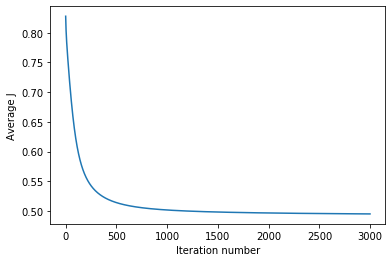

The activation is 1, alpha is 0.25, lambda is 0.01%
    Prediction accuracy is 93.33333333333333%


In [29]:
nn_structure = [4, 30, 3]
    
# train the NN
for activation in [1]:
    for al in [0.25]:
        for la in [0.01]:
            W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000,al,la,activation)
            plt.plot(avg_cost_func)
            plt.ylabel('Average J')
            plt.xlabel('Iteration number')
            plt.show()
            y_pred = predict_y(W, b, X_test, 3,activation)
            print('The activation is {}, alpha is {}, lambda is {}%'.format(activation,al,la))
            print('    Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))
    
#W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000,al,la,activation)

### Ploting the learning curve for iris data for BGD 

Starting gradient descent for 1500 iterations
Iteration 0 of 1500
Iteration 1000 of 1500


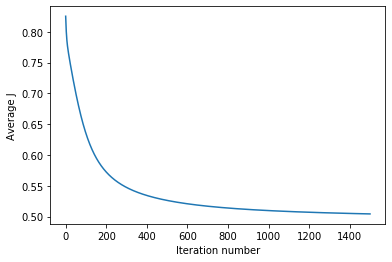

In [14]:
nn_structure = [4, 30, 3]
al = 0.25
la = 0.01
activation = 1
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 1500,al,la,activation)
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()


### Ploting the learning curve for iris data for BGD 

In [15]:
y_pred = predict_y(W, b, X_test, 3,activation)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 91.66666666666666%


### Plotting the learning curve


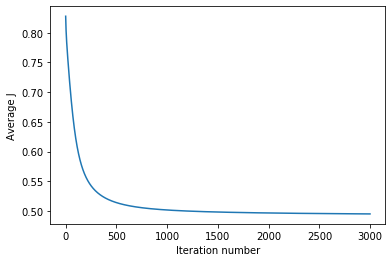

In [30]:
# plot the avg_cost_func
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

## 5) Assessing accuracy
Next we determine what percentage the neural network correctly predicted the handwritten digit correctly on the test set

In [31]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3,3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 88.33333333333333%


Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


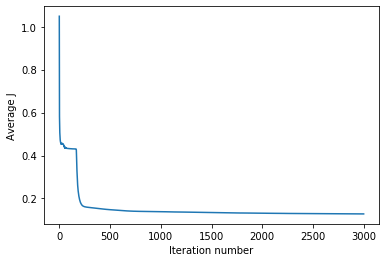

The activation is 2, alpha is 0.25, lambda is 0.01%
    Prediction accuracy is 98.33333333333333%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


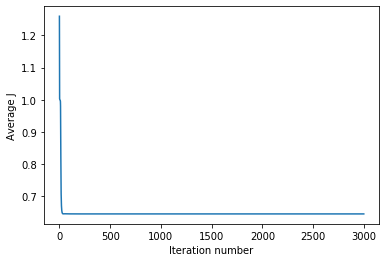

The activation is 2, alpha is 0.25, lambda is 0.5%
    Prediction accuracy is 70.0%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


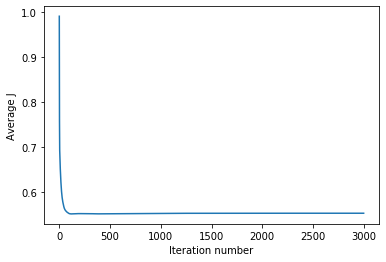

The activation is 2, alpha is 0.25, lambda is 0.05%
    Prediction accuracy is 83.33333333333334%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


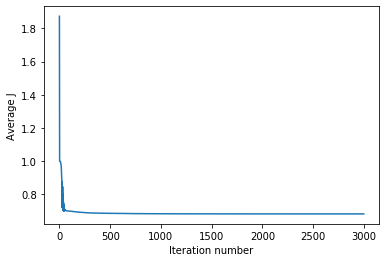

The activation is 2, alpha is 0.5, lambda is 0.01%
    Prediction accuracy is 58.333333333333336%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


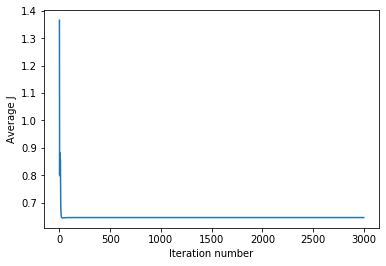

The activation is 2, alpha is 0.5, lambda is 0.5%
    Prediction accuracy is 70.0%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


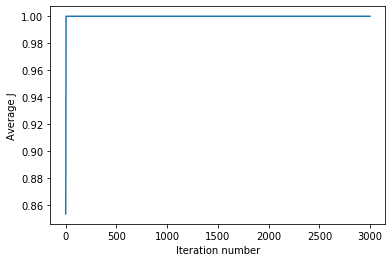

The activation is 2, alpha is 0.5, lambda is 0.05%
    Prediction accuracy is 15.0%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


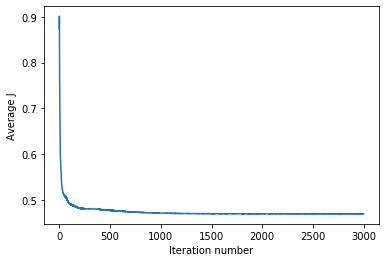

The activation is 2, alpha is 0.8, lambda is 0.01%
    Prediction accuracy is 98.33333333333333%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


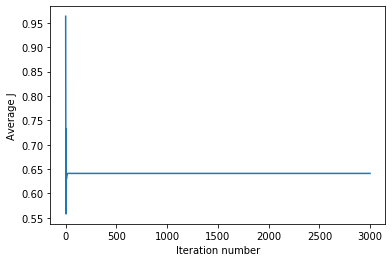

The activation is 2, alpha is 0.8, lambda is 0.5%
    Prediction accuracy is 58.333333333333336%
Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


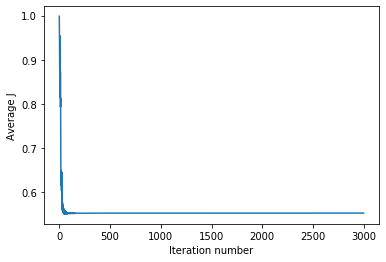

The activation is 2, alpha is 0.8, lambda is 0.05%
    Prediction accuracy is 83.33333333333334%


In [33]:
#digit
#nn_structure = [64, 30, 10]
#iris
nn_structure = [4, 30, 3]
# train the NN
for activation in [2]:
    for al in [0.25,0.5,0.8]:
        for la in [0.01,0.5,0.05]:
            W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000,al,la,activation)
            plt.plot(avg_cost_func)
            plt.ylabel('Average J')
            plt.xlabel('Iteration number')
            plt.show()
            y_pred = predict_y(W, b, X_test, 3,activation)
            print('The activation is {}, alpha is {}, lambda is {}%'.format(activation,al,la))
            print('    Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))
    